In [1]:
!pip install pmdarima


In [2]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# Fix for Matplotlib style
plt.style.use("seaborn-v0_8-darkgrid")



# LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load stock data (e.g., Apple Inc.)
import yfinance as yf
df = yf.download("TATAMOTORS.NS", start="2023-01-24", end=pd.to_datetime("today").strftime('%Y-%m-%d'))

# Keep only the 'Close' price
df = df[['Close']]

df.dropna(inplace=True)
df.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,TATAMOTORS.NS
Date,
2023-01-24,415.967285
2023-01-25,412.912659
2023-01-27,439.073853
2023-01-30,437.152374
2023-01-31,445.478638


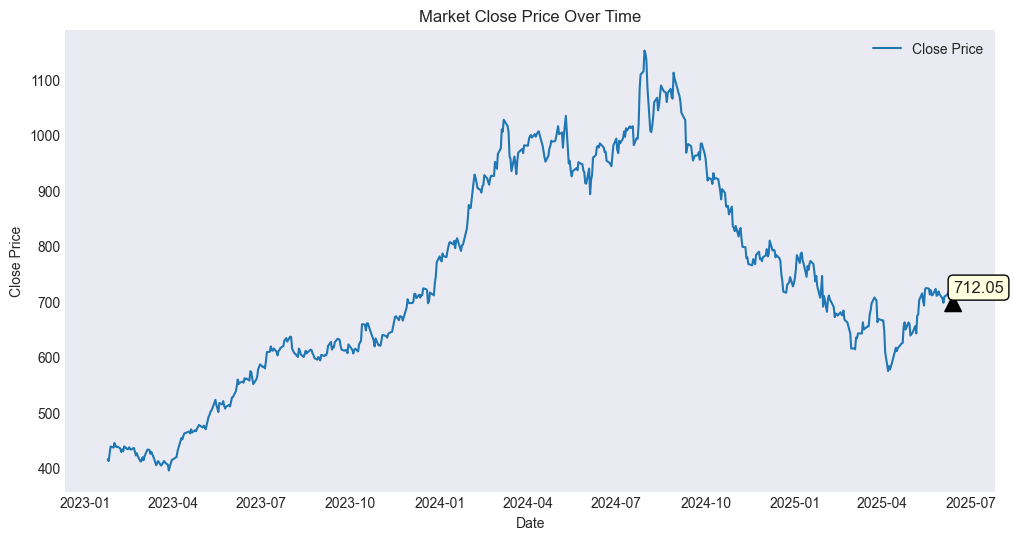

In [3]:
# Plot the data
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Price')

# Get the latest date and price
latest_date = df.index[-1]
latest_price = float(df['Close'].iloc[-1])  # Convert to float explicitly

# Annotate the current price
plt.annotate(f"{latest_price:.2f}",
             xy=(latest_date, latest_price),
             xytext=(latest_date, latest_price + 5),  # Offset the label
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightyellow"))

plt.title("Market Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid()
plt.legend()
plt.show()


In [4]:
# 3. Train-Test Split


# Convert index to datetime and sort
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)

# Define training data up to yesterday, testing for today
train_data = df[df.index < pd.to_datetime("today").normalize()]
test_data = df[df.index >= pd.to_datetime("today").normalize()]


In [5]:
print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")


Train size: 587
Test size: 0


In [6]:
print(df.tail())


Price              Close
Ticker     TATAMOTORS.NS
Date                    
2025-06-09    717.799988
2025-06-10    732.250000
2025-06-11    736.400024
2025-06-12    715.349976
2025-06-13    712.049988


In [7]:
# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Create sequences
def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        # Make sure we're using the correct dimension if data is multi-dimensional
        X.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Check if we have enough data for the sequence length
sequence_length = 60
if len(scaled_data) <= sequence_length:
    # Reduce sequence length if data is insufficient
    sequence_length = max(5, len(scaled_data) // 3)
    print(f"Warning: Reduced sequence length to {sequence_length} due to insufficient data")

X, y = create_sequences(scaled_data, sequence_length)

# Check if sequences were created
if len(X) == 0 or len(y) == 0:
    raise ValueError("Not enough data to create sequences. Try reducing sequence_length or using more data.")

# Train-test split (ensure we have enough data to split)
train_size = int(0.8 * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Make sure we have test data
if len(X_test) == 0:
    # Use the last training example as test if no test data
    X_test = np.expand_dims(X_train[-1], axis=0)
    y_test = np.expand_dims(y_train[-1], axis=0)

# Reshape input for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# feature per timestep, so features = 1.



# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Predict today's close
today_pred_scaled = model.predict(X_test)

# Reshape prediction for inverse transform if needed
if today_pred_scaled.shape[1] != scaled_data.shape[1]:
    # Create a dummy array with the same shape as the original data
    dummy = np.zeros((today_pred_scaled.shape[0], scaled_data.shape[1]))
    # Put the predictions in the first column
    dummy[:, 0] = today_pred_scaled.flatten()
    today_pred_scaled = dummy

today_pred = scaler.inverse_transform(today_pred_scaled)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.1988
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0179
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0101
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0074
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0068
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0061
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0060
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0058
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0042
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0046
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


In [8]:
def predict_market_price(df, model, scaler, days=2):
    df_scaled = scaler.transform(df[-sequence_length:])
    seq_input = np.reshape(df_scaled, (1, sequence_length, 1))

    predictions = []
    input_seq = seq_input.copy()
    
    for _ in range(days):
        pred = model.predict(input_seq)
        predictions.append(pred[0][0])
        input_seq = np.append(input_seq[:, 1:, :], [[[pred[0][0]]]], axis=1)

    # Convert back to original scale
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    prediction_dates = pd.date_range(start=pd.to_datetime("today"), periods=days, freq='B')

    return pd.DataFrame(predictions, index=prediction_dates, columns=["LSTM_Prediction"])


In [9]:
!pip install statsmodels


In [10]:
# Display predicted values for today and tomorrow
predictions = predict_market_price(df[['Close']], model, scaler, days=2)

print("Predictions for Today and Tomorrow:")
print(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predictions for Today and Tomorrow:
                            LSTM_Prediction
2025-06-16 22:03:36.156299       720.987000
2025-06-17 22:03:36.156299       721.400635


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

# 1. Fetch real-time stock data
def fetch_stock_data(ticker="TATAMOTORS.NS", start_date="2023-01-01"):
    df = yf.download(ticker, start=start_date, end=pd.to_datetime("today").strftime('%Y-%m-%d'))
    df = df[['Close']].dropna()
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)
    return df

# 2. Train ARIMA model manually (no auto_arima)
def train_arima_model(train_series, order=(5,1,0)):
    model = ARIMA(train_series, order=order)
    model_fit = model.fit()
    return model_fit

# 3. Predict next 'n' days
def predict_next_days(model_fit, last_date, steps=2):
    forecast = model_fit.forecast(steps=steps)
    forecast_index = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=steps)
    forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=["ARIMA_Prediction"])
    return forecast_df

# 4. Main execution
df = fetch_stock_data("TATAMOTORS.NS")
train_data = df[df.index < pd.to_datetime("today").normalize() - pd.Timedelta(days=1)]['Close']

model_fit = train_arima_model(train_data)
forecast_df = predict_next_days(model_fit, train_data.index[-1], steps=2)

# 5. Plot actual and forecasted prices
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Actual Close Price')
plt.plot(forecast_df['ARIMA_Prediction'], label='ARIMA Forecast (Next 2 Days)', linestyle='--', color='orange')

# Annotate predictions
for idx, value in forecast_df["ARIMA_Prediction"].items():
    plt.annotate(f"{value:.2f}", xy=(idx, value), xytext=(idx, value+5),
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10)

plt.title("ARIMA Forecast for TATAMOTORS")
plt.xlabel("Date")
plt.ylabel("Close Price (INR)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. Print predictions
print("\nPredicted Close Prices:")
for date, value in forecast_df["ARIMA_Prediction"].items():
    print(f"{date.date()}: ₹{value:.2f}")


ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

# Fetch data
df = yf.download("TATAMOTORS.NS", start="2023-01-01")
df = df['Close'].dropna()

# Fit ARIMA
model = ARIMA(df, order=(5,1,0))  # You can tune order (p,d,q)
model_fit = model.fit()

# Forecast next 2 days
forecast = model_fit.forecast(steps=5)
print(forecast)


In [ ]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")

def fetch_and_forecast(ticker="TATAMOTORS.NS", start_date="2023-01-01", forecast_days=2):
    # Step 1: Download stock data
    df = yf.download(ticker, start=start_date)

    # Step 2: Extract Close price as a Series
    close_series = df['Close'].copy()

    # Step 3: Make sure data is numeric and drop missing values
    close_series = pd.to_numeric(close_series, errors='coerce')
    close_series.dropna(inplace=True)

    # Check input type (should be pandas Series)
    print("Type of input to ARIMA:", type(close_series))

    # Ensure it's 1-dimensional
    if close_series.ndim != 1:
        raise ValueError("Input series is not 1-dimensional")

    # Step 4: Fit ARIMA model
    model = ARIMA(close_series, order=(5, 1, 0))
    model_fit = model.fit()

    # Step 5: Forecast next 'forecast_days' points
    forecast = model_fit.forecast(steps=forecast_days)

    # Step 6: Prepare dates for forecast output
    last_date = close_series.index[-1]
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_days)

    print("Predicted Close Prices:")
    for date, price in zip(forecast_dates, forecast):
        print(f"{date.date()}: ₹{price:.2f}")

# Run the function
fetch_and_forecast()



In [ ]:
import pandas as pd
import yfinance as yf
from prophet import Prophet
import matplotlib.pyplot as plt
import datetime
import numpy as np # Import numpy for inf

# Step 1: Fetch stock data
def fetch_stock_data(ticker="TATAMOTORS.NS", start_date="2023-01-01"):
    end_date = datetime.datetime.today().strftime('%Y-%m-%d')
    df = yf.download(ticker, start=start_date, end=end_date)
    df.reset_index(inplace=True)
    df = df[['Date', 'Close']]
    df.dropna(inplace=True)

    # Debug: Check if we have enough data
    if df.empty:
        raise ValueError("Downloaded data is empty. Please check ticker or internet connection.")
    
    print(f"DEBUG: After fetch_stock_data, df shape: {df.shape}")
    print(f"DEBUG: After fetch_stock_data, df head:\n{df.head()}")

    return df

# Step 2: Prepare data for Prophet
def prepare_prophet_data(df):
    df = df.rename(columns={'Date': 'ds', 'Close': 'y'})
    df['ds'] = pd.to_datetime(df['ds'])
    
    # Fix: Ensure 'y' column is a 1D array before converting to numeric
    # This also helps resolve potential TypeError from previous attempt
    df['y'] = pd.to_numeric(df['y'].values.flatten(), errors='coerce') 
    
    print(f"DEBUG: NaNs in df['y'] before initial dropna: {df['y'].isnull().sum()}")

    # Drop rows with NaN values introduced by conversion or already present
    df.dropna(inplace=True)

    print(f"DEBUG: After initial dropna, df shape: {df.shape}")
    
    # Ensure 'y' column is numeric dtype
    if not pd.api.types.is_numeric_dtype(df['y']):
        raise TypeError("The 'y' column is not numeric after initial processing.")

    # Check for infinite values and remove rows containing them
    inf_count = df['y'].isin([np.inf, -np.inf]).sum()
    if inf_count > 0:
        print(f"DEBUG: Found {inf_count} infinite values in 'y' column. Dropping rows with infinite values.")
        df = df[~df['y'].isin([np.inf, -np.inf])].copy() # Use .copy() to avoid SettingWithCopyWarning

    # Crucial check: Ensure DataFrame is not empty after all cleaning steps
    if df.empty:
        raise ValueError("DataFrame is empty after processing and dropping NaNs/Infs. No sufficient data to train the model.")

    # Ensure 'y' is float type explicitly (usually handled by to_numeric, but good for robustness)
    df['y'] = df['y'].astype(float)

    # Sort by 'ds' to ensure Prophet gets time series in correct order
    df = df.sort_values(by='ds').reset_index(drop=True)

    print(f"DEBUG: Final df shape before returning from prepare_prophet_data: {df.shape}")
    print(f"DEBUG: Final df head before returning from prepare_prophet_data:\n{df.head()}")

    return df

# Step 3: Train Prophet model
def train_and_forecast(df, periods=2):
    model = Prophet(daily_seasonality=True)
    model.fit(df)
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    return forecast, model

# Step 4: Show predictions
def display_predictions(forecast, periods=2):
    predictions = forecast[['ds', 'yhat']].tail(periods)
    print("\n📈 Predicted Close Prices:")
    for _, row in predictions.iterrows():
        date = row['ds'].date()
        price = round(row['yhat'], 2)
        print(f"{date}: ₹{price}")

# Step 5: Plot safely
def plot_forecast(model, forecast):
    try:
        fig = model.plot(forecast)
        plt.title("Stock Price Forecast using Prophet")
        plt.xlabel("Date")
        plt.ylabel("Predicted Price")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Plotting Error: {e}")

# Main execution block
if __name__ == "__main__":
    ticker = "TATAMOTORS.NS"  # Change if needed
    try:
        df = fetch_stock_data(ticker)
        df = prepare_prophet_data(df)
        forecast, model = train_and_forecast(df, periods=2)
        display_predictions(forecast, periods=2)
        plot_forecast(model, forecast)
    except Exception as e:
        print(f"An error occurred: {e}")